In [43]:
%matplotlib inline
## imports

# site
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib
import pandas as pd
import numpy as np
import rasterio
import flopy

# std
from pathlib import Path
import datetime
import yaml

In [2]:
def read_array(rasterfile, masked=True,  band=1):
    with rasterio.open(rasterfile) as src:
        return src.read(band, masked=masked)

In [3]:
def read_profile(rasterfile):
    with rasterio.open(rasterfile) as src:
        return src.profile

In [4]:
def write_array(rasterfile, values, profile):
    with rasterio.open(rasterfile, 'w', **profile) as dst:
        return dst.write(values, 1)

In [5]:
def read_3d_array(rasterfiles, stack_axis=0, masked=True):
    arrays = []
    for rasterfile in rasterfiles:
        arrays.append(read_array(rasterfile, masked=masked))
    return np.ma.stack(arrays, axis=stack_axis)

In [6]:
def save_int(datfile, array):
    save_array(datfile, array, fmt='%i', delimiter=' ')


In [7]:
def save_float(datfile, array):
    save_array(datfile, array, fmt='%15.6E')

In [8]:
def save_array(datfile, array, fmt, delimiter=''):
    np.savetxt(datfile, array, fmt=fmt, delimiter=delimiter)

In [55]:
def plot_dphi(fig, ax, dheads, boundaries, extent=None, colorbar=True):
    boundaries = [-b for b in boundaries[::-1]] + boundaries

    cmap = plt.get_cmap('RdBu', len(boundaries) - 1)
    norm = colors.BoundaryNorm(boundaries, len(boundaries) - 1)

    v = ax.imshow(dheads, extent=extent, cmap=cmap, norm=norm, vmin=boundaries[0], vmax=boundaries[-1])
    if colorbar:
        cb = fig.colorbar(v, shrink=0.8)
        cb.set_ticks(boundaries)

In [9]:
t0 = datetime.datetime.now()

In [10]:
## input
# name
name = 'mf6gron_ext'

# workspace
workspace = Path(r'..\output\mf6groningen')

# exe name
exe_name = Path(r'..\bin\mf6.0.4\bin\mf6.exe')

# spatial reference
xllcorner = 228_750.
yllcorner = 576_000.

# grid dimensions
nlay = 11
nrow = 400
ncol = 400
delr = 25.
delc = 25.

# data files
topfile = Path(r'..\data\topbot\RL{ilay:d}.tif')
botfile = Path(r'..\data\topbot\TH{ilay:d}.tif')
               
kdfile = Path(r'..\data\kdc\TX{ilay:d}.tif')
cfile = Path(r'..\data\kdc\CL{ilay:d}.tif')
             
startfile = Path(r'..\data\startingheads\HH{ilay:d}.tif')

rechargefile = Path(r'..\data\recharge\RP1.tif')

drn2005file = Path(r'..\data\topsys\gemiddeld.drn')
ghb2005file = Path(r'..\data\topsys\gemiddeld.ghb')
riv2005file = Path(r'..\data\topsys\gemiddeld.riv')

sqfile = Path(r'..\data\wells\sq_list.csv')

In [11]:
# create workspace directory
workspace.mkdir(exist_ok=True)

In [12]:
# create data directory
datafolder = workspace / 'data'
datafolder.mkdir(exist_ok=True)

In [13]:
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    exe_name=str(exe_name), 
    version='mf6',
    sim_ws=str(workspace))

# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim,
    pname='tdis',
    time_units='DAYS',
    nper=1, 
    perioddata=[(1.0, 1, 1.0)],
    )

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.ModflowGwf(sim,
    modelname=name, 
    model_nam_file=model_nam_file,
    save_flows=True,
    )

In [14]:
# read tops
topfiles = (topfile.parent / topfile.name.format(ilay=i + 1) for i in range(nlay))

tops = read_3d_array(topfiles)

# mask bad nodata values
tops = np.ma.masked_where(tops.mask | (tops < -9990.), tops)

In [15]:
# read bots
botfiles = (botfile.parent / botfile.name.format(ilay=i + 1) for i in range(nlay))

bots = read_3d_array(botfiles)

# mask bad nodata values
bots = np.ma.masked_where(bots.mask | (bots < -9990.), bots)

In [16]:
# convert to top, botm
top = tops[0, :, :].filled(0.)
topdatfile = datafolder / 'top.dat'
save_float(topdatfile, top)
top_ext = {'filename': str(topdatfile.relative_to(workspace))}
botm_ext = []
for ilay in range(nlay):
    botm = bots[ilay, :, :].filled((2*ilay + 1) * -1e-3)
    botmdatfile = datafolder / 'botm_l{ilay:02d}.dat'.format(ilay=ilay*2 + 1)
    save_float(botmdatfile, botm)
    botm_ext.append({'filename': str(botmdatfile.relative_to(workspace))})
    if (ilay + 1) < nlay:
        botm = tops[ilay + 1, :, :].filled((2*ilay + 2) * -1e-3)
        botmdatfile = datafolder / 'botm_l{ilay:02d}.dat'.format(ilay=ilay*2 + 2)
        save_float(botmdatfile, botm)
        botm_ext.append({'filename': str(botmdatfile.relative_to(workspace))})

In [17]:
# initialize the DIS package
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf,
    pname='dis', nlay=(nlay*2 - 1),
    nrow=nrow, ncol=ncol,
    delr=delr, delc=delc,
    top=top_ext, botm=botm_ext,
    idomain=1,
    length_units='METERS',
    )

In [18]:
# read kD
kdfiles = (kdfile.parent / kdfile.name.format(ilay=i + 1) for i in range(nlay))
kd = read_3d_array(kdfiles)

# convert to kh
kh = (kd / (tops - bots))

# fill with low value
kh = kh.filled(1e-6)

# write to file
kh_ext = []
for ilay in range(nlay):
    khdatfile = datafolder / 'kh_l{ilay:02d}.dat'.format(ilay=ilay*2 + 1)
    save_float(khdatfile, kh[ilay, :, :])
    kh_ext.append(
        {'filename': str(khdatfile.relative_to(workspace))},
        )
    if (ilay + 1) < nlay:
        # dummy values
        kh_ext.append(1e-6)

In [19]:
# read c
cfiles = (cfile.parent / cfile.name.format(ilay=i + 1) for i in range(nlay - 1))
c = read_3d_array(cfiles)

# convert to kv
kv = (bots[:-1, :, :] - tops[1:, :, :]) / c

# fill with high value
kv = kv.filled(1e6)

# write to file
kv_ext = []
for ilay in range(nlay):
    # dummy values
    kv_ext.append(1e6)
    if (ilay + 1) < nlay:
        kvdatfile = datafolder / 'kv_l{ilay:02d}.dat'.format(ilay=ilay*2 + 2)
        save_float(kvdatfile, kv[ilay, :, :])
        kv_ext.append(
            {'filename': str(kvdatfile.relative_to(workspace))},
            )

In [20]:
# initialize the NPF package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    model=gwf,
    k=kh_ext,
    k22=kh_ext,
    k33=kv_ext,
)

In [21]:
# read start
startfiles = (startfile.parent / startfile.name.format(ilay=i + 1) for i in range(nlay))
start = read_3d_array(startfiles)

# mask values larger than 1000
start = np.ma.masked_where(start.mask | (start > 1e3), start)

# fill masked with zeros
start = start.filled(0.)

start_ext = []
for ilay in range(nlay):
    startdatfile = datafolder / 'start_l{ilay:02d}.dat'.format(ilay=ilay*2 + 1)
    save_float(startdatfile, start[ilay, :, :])
    start_ext.append(
        {'filename': str(startdatfile.relative_to(workspace))},
        )
    if (ilay + 1) < nlay:
        start_ext.append(
            {'filename': str(startdatfile.relative_to(workspace))},
            )

In [22]:
# Create the initial conditions package
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=start_ext)

In [23]:
# get boundary data from starting heads
isboundary = np.zeros((nrow, ncol)).astype(np.bool)

# square model: set first row, last row, first column, last column to true
isboundary[0, :] = True
isboundary[-1, :] = True
isboundary[:, 0] = True
isboundary[:, -1] = True

chd_data = []
for ilay in range(dis.nlay.get_data()):    
    for row, col in np.ndindex(*isboundary.shape):
        if isboundary[row, col]:
            chd_data.append((ilay + 1, row + 1, col + 1, start[ilay//2, row, col]))
chd_data = np.array(
    chd_data,
    dtype=[('ilay', np.int), ('row', np.int), ('col', np.int), ('value', np.float)]
    )
chddatfile = datafolder / 'chd.dat'
save_array(chddatfile, chd_data, fmt='  %i %i %i %16.8f')
chd_ext = {0: {
    'filename': str(chddatfile.relative_to(workspace)),
    }}

In [24]:
# initialize the CHD package
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf,
    pname='chd',
    maxbound=len(chd_data),
    stress_period_data=chd_ext,
    )

In [25]:
# recharge
recharge = read_array(rechargefile).filled(0.)
rechargedatfile = datafolder / 'recharge.dat'
save_float(rechargedatfile, recharge)
recharge_ext = [{'filename': str(rechargedatfile.relative_to(workspace))}]

In [26]:
# initialize the RCH package
rch = flopy.mf6.ModflowGwfrcha(gwf, pname='rch', recharge=recharge_ext)

In [27]:
# DRN stress period data from Modflow 2005
drn2005_data = pd.read_csv(drn2005file, skiprows=6, delim_whitespace=True)
drn2005_data.columns = ['k', 'i', 'j', 'elev0', 'cond0']



drn_data = drn2005_data.loc[:, ['k', 'i', 'j', 'elev0', 'cond0']]
drn_data.loc[:, 'k'] *= 2
# drn_data.loc[:, ['k', 'i', 'j']] += 1

drndatfile = datafolder / 'drn.dat'
save_array(drndatfile, drn_data.values, fmt='  %i %i %i %16.8f %16.8f')
drn_ext = {0: {
    'filename': str(drndatfile.relative_to(workspace)),
    }}

# initialize the DRN package
drn = flopy.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,
    pname='drn',
    maxbound=drn_data.shape[0],
    stress_period_data=drn_ext,
    )

In [28]:
# RIV stress period data from Modflow 2005
riv2005_data = pd.read_csv(riv2005file, skiprows=6, delim_whitespace=True)
riv2005_data.columns = ['k', 'i', 'j', 'stage0', 'cond0', 'rbot0']

riv_data = riv2005_data.loc[:, ['k', 'i', 'j', 'stage0', 'cond0', 'rbot0']]
riv_data.loc[:, 'k'] *= 2
# riv_data.loc[:, ['k', 'i', 'j']] += 1

rivdatfile = datafolder / 'riv.dat'
save_array(rivdatfile, riv_data.values, fmt='  %i %i %i %16.8f %16.8f %16.8f')
riv_ext = {0: {
    'filename': str(rivdatfile.relative_to(workspace)),
    }}

# initialize the RIV package
riv = flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf,
    pname='riv',
    maxbound=riv_data.shape[0],
    stress_period_data=riv_ext,
    )

In [29]:
# read sources data from csv file
sqs = pd.read_csv(sqfile)

# to row,col from x,y
fwd = rasterio.transform.from_origin(xllcorner, yllcorner + nrow*delr, delc, delr)

# transform xy to row,col
sqs.loc[:, 'row'], sqs.loc[:, 'col'] = (
    rasterio.transform.rowcol(fwd, sqs.loc[:, 'x'], sqs.loc[:,'y'])
    )

# select wells in model
in_model = (
    (sqs.loc[:, 'row'] >= 0) & (sqs.loc[:, 'row'] < nrow) &
    (sqs.loc[:, 'col'] >= 0) & (sqs.loc[:, 'col'] < ncol)
    )
sqs = sqs.loc[in_model, :]

# layer numbers & pumping rates
wel_data = sqs.loc[:, ['ilay', 'row', 'col', 'q_assigned']]
wel_data.loc[:, 'ilay'] = wel_data.loc[:, 'ilay'] * 2 - 1
wel_data.loc[:, ['row', 'col']] += 1

weldatfile = datafolder / 'wel.dat'
save_array(weldatfile, wel_data.values, fmt='  %i %i %i %16.8f')
wel_ext = {0: {
    'filename': str(weldatfile.relative_to(workspace)),
    }}

In [30]:
# initialize WEL package
wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(gwf,
    pname='wel',
    maxbound=len(wel_data),
    stress_period_data=wel_ext,
    )

In [31]:
# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname='ims', complexity='SIMPLE')

In [32]:
# Create the output control package
headfile = '{}.hds'.format(name)
head_filerecord = [headfile]
budgetfile = '{}.cbb'.format(name)
budget_filerecord = [budgetfile]
saverecord = [('HEAD', 'ALL'), 
              ('BUDGET', 'ALL')]
printrecord = [('HEAD', 'LAST')]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc', saverecord=saverecord, 
                                            head_filerecord=head_filerecord,
                                            budget_filerecord=budget_filerecord,
                                            printrecord=printrecord)

In [33]:
# write simulation to new location
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mf6gron_ext...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package chd...
    writing package rch...
    writing package drn...
    writing package riv...
    writing package wel...
    writing package oc...


In [34]:
# Run the simulation
success, buff = sim.run_simulation()
print('\nSuccess is: ', success)

FloPy is using the following  executable to run the model: ..\bin\mf6.0.4\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/07/2019

   MODFLOW 6 compiled Mar 07 2019 17:09:37 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resou

In [35]:
# read heads
headfile = workspace / '{name:}.hds'.format(name=name)
hds = flopy.utils.binaryfile.HeadFile(headfile)
heads = np.ma.masked_equal(hds.get_data(), 1e30)

In [36]:
t1 = datetime.datetime.now()
print('notebook execution took {}'.format(t1 - t0))

notebook execution took 0:02:26.910466


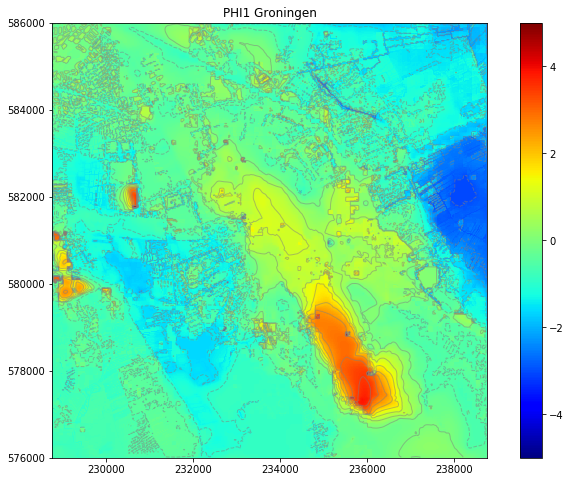

In [40]:
# plot heads
fig, ax = plt.subplots(figsize=(12, 8))
mm = flopy.plot.PlotMapView(gwf, ax=ax)

extent = [xllcorner, xllcorner + ncol*delc, yllcorner, yllcorner + nrow*delr]
v = ax.imshow(heads[0, :, :], cmap='jet', vmin=-5., vmax=5., extent=extent)

contour_levels = np.arange(-5., 5., 0.5)
cs = ax.contour(heads[0, :, :], levels=contour_levels, linewidths=1., colors='gray', alpha=0.5, extent=extent, origin='upper')

ax.set_aspect('equal')
ax.set_title('PHI1 Groningen')
plt.colorbar(v)

plt.savefig(workspace / 'phi1.png', bbox_inches='tight', dpi=200)

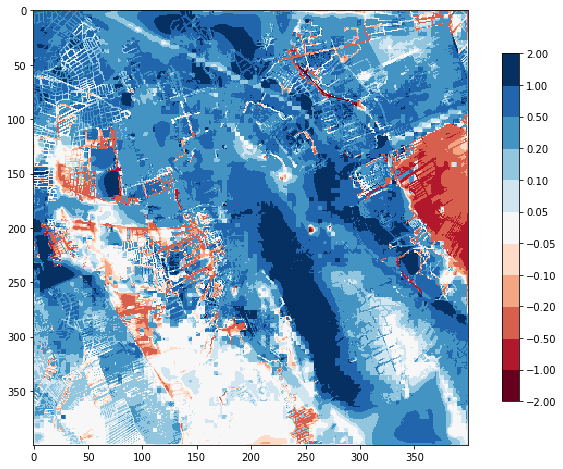

In [56]:
# plot difference between layer 1 and layer 5
dheads = heads[0, :, :] - heads[5*2 - 2, :, :]
boundaries = [0.05, 0.1, 0.2, 0.5, 1., 2.]

fig, ax = plt.subplots(figsize=(12, 8))
plot_dphi(fig, ax, dheads, boundaries)

ax.set_aspect('equal')
ax.set_title('PHI1 - PHI5')

plt.savefig(workspace / 'dphi1_phi5.png', bbox_inches='tight', dpi=200)